In [76]:
import networkx as nx
import random
import numpy as np
import random
import matplotlib.pyplot as plt

import dimod
import dwave
import dwave.system
import plotly.graph_objects as go

In [2]:
def generate_random_instance(n_machine, n_job, max_duration, timespan):

    instance = {}
    machine_list = list(range(n_machine))

    for i in range(n_job):
        random.shuffle(machine_list)
        instance[i] = []
        for j in range(n_machine):
            instance[i].append((machine_list[j], random.randint(1,max_duration)))
    instance['timespan'] = timespan
    
    return instance

In [193]:
n_jobs = 3
n_machines = 3
max_duration = 2
timespan = 6

instance = generate_random_instance(n_machines, n_jobs, max_duration, timespan)
instance

{0: [(1, 1), (0, 2), (2, 2)],
 1: [(1, 2), (0, 1), (2, 2)],
 2: [(0, 1), (2, 2), (1, 1)],
 'timespan': 6}

In [129]:
def get_variables(instance):

    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1

    variables = np.zeros((n_machines, n_jobs, instance['timespan']))
    
    return variables


In [130]:
variables = get_variables(instance)
variables.shape

(3, 3, 6)

In [243]:
graph = nx.Graph()
job_groups = {}

for j in range(n_jobs):
        x = 1/4*j
        job_groups[j] = []
        for m in range(n_machines):
            x += 1
            for t in range(timespan):
                  y=(timespan-t)/3
                  graph.add_node((m,j,t), pos=[x,y])
                  job_groups[j].append((m,j,t))

task_groups = {}

m_seq = {}

for job in range(n_jobs):
      m_seq[job] = []
      for task in instance[job]:
            m_seq[job].append(task[0])

for job in m_seq:
      task_groups[job] = []
      
      for m in m_seq[job]:
            tmp = []

            for node in job_groups[job]:
                  if m == node[0]:
                        tmp.append(node)

            task_groups[job].append(tmp)


pos_dict = {}

for n in graph.nodes:
    pos_dict[n] = graph.nodes[n]['pos']

In [227]:
task_groups

{0: [[(1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 0, 4), (1, 0, 5)],
  [(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 0, 5)],
  [(2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (2, 0, 4), (2, 0, 5)]],
 1: [[(1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 4), (1, 1, 5)],
  [(0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5)],
  [(2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 1, 4), (2, 1, 5)]],
 2: [[(0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 2, 4), (0, 2, 5)],
  [(2, 2, 0), (2, 2, 1), (2, 2, 2), (2, 2, 3), (2, 2, 4), (2, 2, 5)],
  [(1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 2, 4), (1, 2, 5)]]}

In [219]:
instance

{0: [(1, 1), (0, 2), (2, 2)],
 1: [(1, 2), (0, 1), (2, 2)],
 2: [(0, 1), (2, 2), (1, 1)],
 'timespan': 6}

In [131]:
def soo_edges(instance):
    curved_edges = []
    straight_edges = []

    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']
    
    for m in range(n_machines):
        for j in range(n_jobs):
            for t in range(timespan-1):
                for k in range(t+1,timespan):
                    if abs(t-k) > 1:
                        curved_edges.append(((m,j,t),(m,j,k)))
                    else:
                        straight_edges.append(((m,j,t),(m,j,k)))
    
    return curved_edges, straight_edges

In [151]:
instance[0]

[(2, 1), (1, 2), (0, 2)]

In [155]:
def oo_edges(instance):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']
    edges = []

    for job in instance:
        if job != 'timespan':
            for i in range(n_machines-1):
                task = instance[job][i]
                m = task[0]
                p = task[1]
                for t in range(timespan):
                    t_max = t + p
                    for t_p in range(t_max-1):
                        task_p = instance[job][i+1]
                        m_p = task_p[0]
                        p_p = task_p[1]

                        edges.append(((m,job,t),(m_p,job,t_p)))
        
    return edges

In [126]:
soo_curved, soo_straight = soo_edges(variables)

In [157]:
oo_straight = oo_edges(instance)
len(oo_straight)

114

In [101]:
graph.add_edges_from(curved)
graph.add_edges_from(straight)

In [244]:
graph.add_edges_from(oo_straight)

In [103]:
graph.edges

EdgeView([((0, 0, 0), (0, 0, 2)), ((0, 0, 0), (0, 0, 3)), ((0, 0, 0), (0, 0, 4)), ((0, 0, 0), (0, 0, 5)), ((0, 0, 0), (0, 0, 1)), ((0, 0, 1), (0, 0, 3)), ((0, 0, 1), (0, 0, 4)), ((0, 0, 1), (0, 0, 5)), ((0, 0, 1), (0, 0, 2)), ((0, 0, 2), (0, 0, 4)), ((0, 0, 2), (0, 0, 5)), ((0, 0, 2), (0, 0, 3)), ((0, 0, 3), (0, 0, 5)), ((0, 0, 3), (0, 0, 4)), ((0, 0, 4), (0, 0, 5)), ((0, 1, 0), (0, 1, 2)), ((0, 1, 0), (0, 1, 3)), ((0, 1, 0), (0, 1, 4)), ((0, 1, 0), (0, 1, 5)), ((0, 1, 0), (0, 1, 1)), ((0, 1, 1), (0, 1, 3)), ((0, 1, 1), (0, 1, 4)), ((0, 1, 1), (0, 1, 5)), ((0, 1, 1), (0, 1, 2)), ((0, 1, 2), (0, 1, 4)), ((0, 1, 2), (0, 1, 5)), ((0, 1, 2), (0, 1, 3)), ((0, 1, 3), (0, 1, 5)), ((0, 1, 3), (0, 1, 4)), ((0, 1, 4), (0, 1, 5)), ((0, 2, 0), (0, 2, 2)), ((0, 2, 0), (0, 2, 3)), ((0, 2, 0), (0, 2, 4)), ((0, 2, 0), (0, 2, 5)), ((0, 2, 0), (0, 2, 1)), ((0, 2, 1), (0, 2, 3)), ((0, 2, 1), (0, 2, 4)), ((0, 2, 1), (0, 2, 5)), ((0, 2, 1), (0, 2, 2)), ((0, 2, 2), (0, 2, 4)), ((0, 2, 2), (0, 2, 5)), ((0, 2

In [172]:
for i in node_groups:
    print(i)

0
1
2


In [229]:
len(task_groups[0])

3

TypeError: 'int' object is not iterable

In [246]:
labels

{(1, 2, 0): 2,
 (1, 2, 1): 2,
 (1, 2, 2): 2,
 (1, 2, 3): 2,
 (1, 2, 4): 2,
 (1, 2, 5): 2}

In [251]:
labels

{(1, 2, 0): '2',
 (1, 2, 1): '2',
 (1, 2, 2): '2',
 (1, 2, 3): '2',
 (1, 2, 4): '2',
 (1, 2, 5): '2'}

In [252]:
instance

{0: [(1, 1), (0, 2), (2, 2)],
 1: [(1, 2), (0, 1), (2, 2)],
 2: [(0, 1), (2, 2), (1, 1)],
 'timespan': 6}

[(1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 0, 4), (1, 0, 5)]
[(1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 4), (1, 1, 5)]
[(0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 2, 4), (0, 2, 5)]


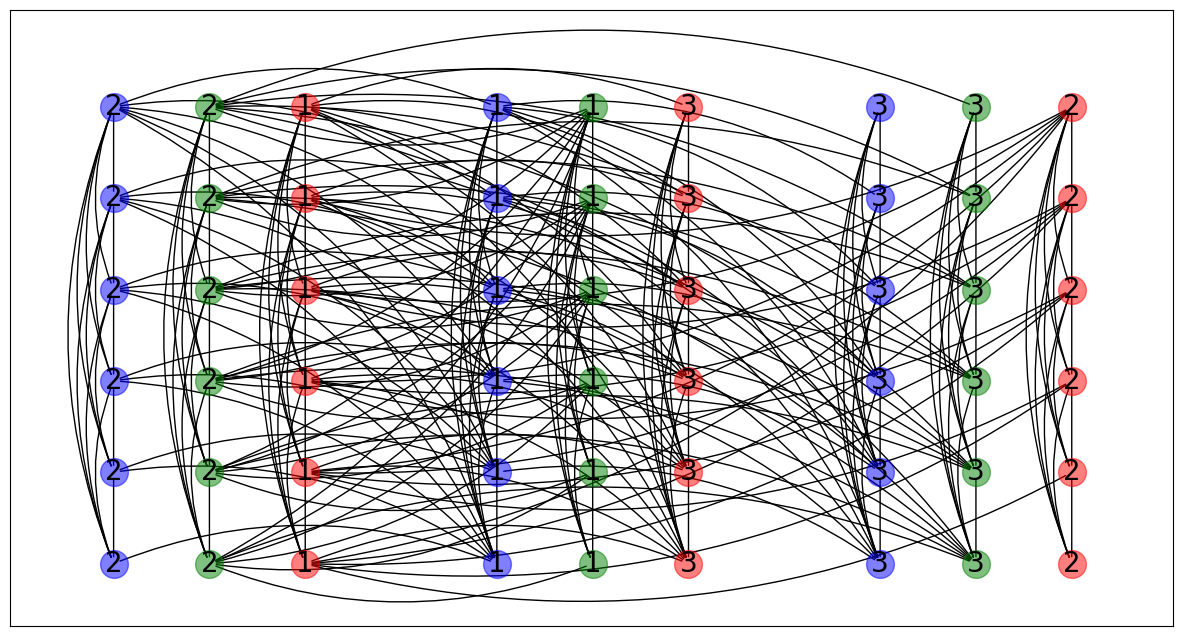

In [266]:
plt.figure(figsize=(15,8))
colors = ['b','g','r','c','m']

labels = list(range(3))

for job in task_groups:
    for i,task in enumerate(task_groups[job]):
        if i==0:
            print(task)
        nx.draw_networkx_nodes(graph, pos_dict, node_size=400, nodelist=task, node_color=colors[job], alpha=0.5)

        labels = dict( zip(task,[str(i+1) for j in range(len(task))] ))

        nx.draw_networkx_labels(graph, pos_dict, labels, font_size=20)
nx.draw_networkx_edges(graph, pos_dict, node_size=100, edgelist=soo_curved, arrows=True, connectionstyle="arc3,rad=0.2")
nx.draw_networkx_edges(graph, pos_dict, node_size=100, edgelist=soo_straight, arrows=True, connectionstyle="arc3")
nx.draw_networkx_edges(graph, pos_dict, node_size=100, edgelist=oo_straight, arrows=True, connectionstyle="arc3,rad=0.2")


plt.show()

In [169]:
plt.colormaps['Set1']

TypeError: 'ListedColormap' object is not subscriptable